In [1]:
import torch
from torch.autograd import Variable
dtype = torch.FloatTensor

In [2]:
import numpy as np
pi = np.pi

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt

## Simultaneous search for policy and verifying Lyapunov function

$$\dot{x} = f(x,u)$$

$$ u = \pi_\theta(x)) $$

$$ V(x) = p.s.d. \text{by construction, but parameterized by parameters } \psi $$

$$ \dot{V} = \frac{dV}{dx} \dot{x}$$
$$ = \big[ \frac{dV}{dx}\big]^T \big[f(x,\pi_{\theta}(x) \big] $$

### Loss function

$X$ = {$x_1, x_2, ..., x_N$} many samples

$$ L(\theta) = \sum_{i} l(x_i, \theta) $$

\begin{equation}
  \mathcal{l}(x_i,\theta) =
  \begin{cases}
    \dot{V}(x_i, \theta) & \text{if $\dot{V}(x_i, \theta) > 0$} \\
    0 & \text{otherwise}
  \end{cases}
\end{equation}



In [4]:
l = 1.0   # length in pixels
g = 1.0    # gravity in m/s**2
m = 1.0    # mass in kg
b = 1.0    # damping

x_i = Variable(torch.FloatTensor([1.0, 1.1]).type(dtype), requires_grad=True)
print x_i

P = Variable(torch.FloatTensor([1, 1]).type(dtype), requires_grad=True)
print P
### Step 1: compute V(x)
def compute_V(x):
    '''V(x) = x_1^2 + x_2^2'''
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    x_squared = (x-x_desired).pow(2)
    return torch.dot(P, x_squared)

def compute_V_energy_based(x):
    '''V(x) = (E - E_d)^2'''
    energy = 0.5*m*l**2*x[1]**2 + m*g*l*torch.cos(x[0])
    energy_desired = m*g*l
    difference_squared = (energy-energy_desired).pow(2)
    return difference_squared

print x_i.shape
print "V is", compute_V_energy_based(x_i)
x_i_2 = Variable(torch.FloatTensor([1.1, 2.2]).type(dtype), requires_grad=True)
print "V is", compute_V_energy_based(x_i_2)

many_x_i = Variable(torch.FloatTensor([[1.0, 1.1, 2.0],[1.1, 2.2, 3.0]]).type(dtype), requires_grad=True)

def compute_V_vectorized(x):
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    x_desired_vectorized = torch.t(x_desired.repeat(x.shape[1], 1))
    x_squared = (x-x_desired_vectorized).pow(2)
    P_transpose = torch.t(P.unsqueeze(1))
    return P_transpose.mm(x_squared)

def compute_V_energy_based_vectorized(x):
    energy_vectorized = 0.5*m*l**2*x[1,:]**2 + m*g*l*torch.cos(x[0,:])
    energy_desired = m*g*l
    difference_squared = (energy_vectorized-energy_desired).pow(2)
    return difference_squared
    
print many_x_i
print compute_V_energy_based_vectorized(many_x_i)

Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

Variable containing:
 1
 1
[torch.FloatTensor of size 2]

torch.Size([2])
V is Variable containing:
1.00000e-02 *
  2.1113
[torch.FloatTensor of size 1]

V is Variable containing:
 3.5104
[torch.FloatTensor of size 1]

Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Variable containing:
 0.0211
 3.5104
 9.5102
[torch.FloatTensor of size 3]



In [9]:
### Step 2: compute dV/dx

### Step 3: initialize policy parameters
K = Variable(torch.FloatTensor([1, 2]).type(dtype), requires_grad=True)
print K

### Step 4: define dynamics function
def dynamics(x):
    xdot = Variable(torch.zeros(2).type(dtype))
    xdot[0] = x[1]
    xdot[1] = -torch.dot(K,x)
    return xdot

def pendulum_policy(x):
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    return -torch.dot(K,x-x_desired)

def pendulum_energy_policy(x):
    energy = 0.5*m*l**2*x[1]**2 + m*g*l*torch.cos(x[0])
    energy_desired = m*g*l
    return -K[0]*x[1]*(energy - energy_desired)

def pendulum_dynamics(x):
    xdot = Variable(torch.zeros(2).type(dtype))
    xdot[0] = x[1]
    u = pendulum_policy(x)
    xdot[1] = (m * g * l * torch.sin(x[0:1])) - b*x[1] + u
    return xdot
    
xdot = pendulum_dynamics(x_i)
print xdot
print pendulum_dynamics(x_i_2)
print "energy policy is", pendulum_energy_policy(x_i)
print "energy policy is", pendulum_energy_policy(x_i_2)

many_x_i = Variable(torch.FloatTensor([[1.0, 1.1, 2.0],[1.1, 2.2, 3.0]]).type(dtype), requires_grad=True)

def dynamics_vectorized(x):
    xdot = Variable(torch.zeros(2,x.shape[1]).type(dtype))
    xdot[0,:] = x[1,:]
    K_transpose = torch.t(K.unsqueeze(1))
    xdot[1,:] = -K_transpose.mm(x)
    return xdot

def pendulum_policy_vectorized(x):
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    x_desired_vectorized = torch.t(x_desired.repeat(x.shape[1], 1))
    K_transpose = torch.t(K.unsqueeze(1))
    return -K_transpose.mm(x - x_desired_vectorized)

def pendulum_energy_policy_vectorized(x):
    energy_vectorized = 0.5*m*l**2*x[1,:]**2 + m*g*l*torch.cos(x[0,:])
    energy_desired = m*g*l
    return -K[0]*x[1,:]*(energy_vectorized - energy_desired)

def pendulum_dynamics_vectorized(x):
    xdot = Variable(torch.zeros(2,x.shape[1]).type(dtype))
    xdot[0,:] = x[1,:]
    u = pendulum_policy_vectorized(x)
    xdot[1,:] = (m * g * l * torch.sin(x[0:1])) - b*x[1] + u
    return xdot
      
print many_x_i
print pendulum_dynamics_vectorized(many_x_i)
print "energy policy is", pendulum_energy_policy_vectorized(many_x_i)

 Variable containing:
 1
 2
[torch.FloatTensor of size 2]

Variable containing:
 1.1000
-3.4585
[torch.FloatTensor of size 2]

Variable containing:
 2.2000
-6.8088
[torch.FloatTensor of size 2]

energy policy is Variable containing:
-0.1598
[torch.FloatTensor of size 1]

energy policy is Variable containing:
-4.1219
[torch.FloatTensor of size 1]

Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Variable containing:
  1.1000   2.2000   3.0000
 -3.4585  -6.8088 -10.0907
[torch.FloatTensor of size 2x3]

energy policy is Variable containing:
-0.1598
-4.1219
-9.2516
[torch.FloatTensor of size 3]



In [9]:
def compute_Vdot(x):
    V = compute_V_energy_based(x)
#     print x.shape
#     print V.shape
#     print V
    V.backward(torch.ones(1).type(dtype),retain_graph=True)
#     print "x.grad is", x.grad
    jacobian_x = Variable(x.grad.data)
#     print "jacobian_x is", jacobian_x
    f = pendulum_dynamics(x)
    Vdot = torch.dot(jacobian_x,f)
    return Vdot

print "x_i is", x_i
if x_i.grad is not None:
    print x_i.grad.zero_()
Vdot = compute_Vdot(x_i)
print "Vdot is", Vdot
Vdot.backward()

def compute_Vdot_vectorized(x):
    V = compute_V_energy_based_vectorized(x)
#     print V
#     print x.shape
#     print "x.grad is", x.grad
#    V.backward(torch.ones(1,1).type(dtype),retain_graph=True)
#     print x
    V.backward(torch.ones(1,x.shape[1]).type(dtype),retain_graph=True)
    jacobian_x = Variable(x.grad.data)
#     print "jacobian_x is", jacobian_x
    f = pendulum_dynamics_vectorized(x)
    Vdot = (jacobian_x*f).sum(dim=0)
    return Vdot

print "many_x_i is", many_x_i

Vdot_vec = compute_Vdot_vectorized(many_x_i)
print "Vdot_vec is", Vdot_vec
#Vdot.backward(torch.ones(many_x_i.shape[1]).type(dtype))
cost = Vdot_vec.clamp(min=0).sum()
print cost
cost.backward()
many_x_i.grad.data.zero_()



x_i is Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

Vdot is Variable containing:
-1.3746
[torch.FloatTensor of size 1]

many_x_i is Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Vdot_vec is Variable containing:
  -1.3746
 -63.4774
-203.5343
[torch.FloatTensor of size 3]

Variable containing:
 0
[torch.FloatTensor of size 1]




 0  0  0
 0  0  0
[torch.FloatTensor of size 2x3]

## First let's verify, no synthesis
 
K = [1, 2] and P = [1, 1] should be stable

In [10]:
K = Variable(torch.FloatTensor([1, 2]).type(dtype), requires_grad=True)
P = Variable(torch.FloatTensor([1, 1]).type(dtype), requires_grad=True)
for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        break

false, counterexample found:  Variable containing:
-0.9493
-0.6727
[torch.FloatTensor of size 2]



## Now let's search for K, from an initialization not stable

In [11]:
P = Variable(torch.rand(2).type(dtype), requires_grad=True)
K = Variable(torch.randn(2).type(dtype), requires_grad=True)

print "Initial P", P
print "Initial K", K


for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        break

Initial P Variable containing:
 0.6778
 0.7110
[torch.FloatTensor of size 2]

Initial K Variable containing:
 0.0857
-0.5708
[torch.FloatTensor of size 2]

false, counterexample found:  Variable containing:
-1.7950
-1.2983
[torch.FloatTensor of size 2]



In [12]:
# Reset 
P = Variable(torch.rand(2).type(dtype), requires_grad=True)
K = Variable(torch.randn(2).type(dtype), requires_grad=True)

<IPython.core.display.Javascript object>


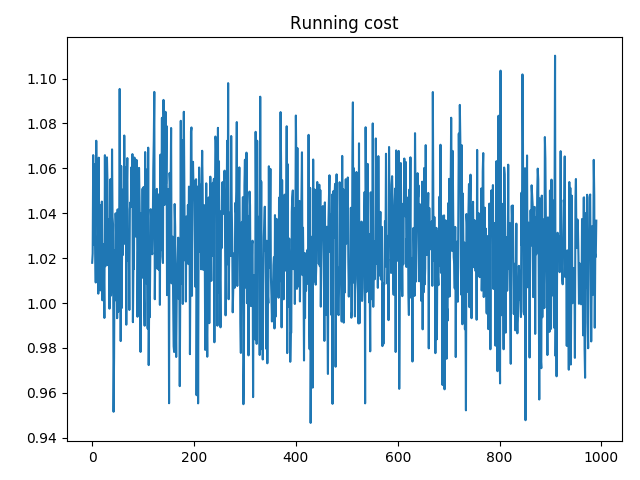

In [13]:
## optimization plotting tool

cost_current_iteration = 0
cost_history = []
cost_iteration_number_history = []

f, (cost_axis) = plt.subplots(1, 1)

cost_axis.plot(cost_iteration_number_history, cost_history)
cost_axis.set_title('Running cost')

plt.tight_layout()

In [14]:
## optimize

num_iterations = 1000
num_samples_per_iteration = 10000
step_rate = 1e-4
slack_var = .00

# K has already been initialized above, and initial policy visualized

import time
print "first P is", P
print "first K is", K

for cost_iteration in range(num_iterations):
    
    start = time.time()
    
    cost = 0
    
    samples = 0.2*(torch.rand(2,num_samples_per_iteration).type(dtype)*2 - torch.ones(2,num_samples_per_iteration))
    many_x_i = Variable(samples, requires_grad=True)
    Vdot = compute_Vdot_vectorized(many_x_i)
    cost = Vdot.clamp(min=-slack_var).sum()
        
    ## Automatically differentiate
    cost.backward()

    # Update K via gradient descent
    K.data -= step_rate * K.grad.data
    #P.data -= step_rate * P.grad.data
    
    # Project P into feasible
    #P.data = torch.abs(P.data)
    # Make P numerically stable by normalizing
    #P.data = P.data/(P.data.pow(2).sum())
      
    # Manually zero the gradients after running the backward pass
    K.grad.data.zero_()
    #P.grad.data.zero_()
    
    print time.time() - start, "is time for one step of grad descent"
    print 
    print cost.data[0]
    
    # handle plotting
    cost_history.append(cost.data[0])
    cost_iteration_number_history.append(cost_iteration)
    
    if cost_iteration % 10 == 0:
        cost_axis.lines[0].set_xdata(cost_iteration_number_history)
        cost_axis.lines[0].set_ydata(cost_history)
        cost_axis.relim()
        cost_axis.autoscale_view()
        cost_axis.figure.canvas.draw()
        
    if cost.data[0] == 0:
        break
        
    print "P is", P
    print "K is", K
    
    if cost_iteration == num_iterations - 1:
        print "didn't converge"

first P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

first K is Variable containing:
 1.3870
 1.7091
[torch.FloatTensor of size 2]

0.00827312469482 is time for one step of grad descent

1.01793253422
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3870
 1.7090
[torch.FloatTensor of size 2]

0.00307583808899 is time for one step of grad descent

1.0220925808
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3869
 1.7090
[torch.FloatTensor of size 2]

0.00295495986938 is time for one step of grad descent

1.06590199471
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3869
 1.7090
[torch.FloatTensor of size 2]

0.00294399261475 is time for one step of grad descent

1.02604937553
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3869
 1.7089
[torch.FloatTe

P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3862
 1.7075
[torch.FloatTensor of size 2]

0.00260996818542 is time for one step of grad descent

0.996036589146
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3862
 1.7075
[torch.FloatTensor of size 2]

0.00288987159729 is time for one step of grad descent

1.01625299454
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3862
 1.7075
[torch.FloatTensor of size 2]

0.00282216072083 is time for one step of grad descent

1.02922785282
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3862
 1.7074
[torch.FloatTensor of size 2]

0.00282406806946 is time for one step of grad descent

1.09537696838
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3862
 1.7074
[torch.FloatTensor of si

P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3853
 1.7057
[torch.FloatTensor of size 2]

0.00224709510803 is time for one step of grad descent

0.972369492054
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3853
 1.7057
[torch.FloatTensor of size 2]

0.00226712226868 is time for one step of grad descent

1.00262105465
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3853
 1.7056
[torch.FloatTensor of size 2]

0.0020489692688 is time for one step of grad descent

0.993673563004
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3853
 1.7056
[torch.FloatTensor of size 2]

0.00210785865784 is time for one step of grad descent

1.01866948605
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3852
 1.7056
[torch.FloatTensor of si

P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3844
 1.7039
[torch.FloatTensor of size 2]

0.00280404090881 is time for one step of grad descent

1.02475965023
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3844
 1.7039
[torch.FloatTensor of size 2]

0.0026171207428 is time for one step of grad descent

0.962988615036
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3844
 1.7038
[torch.FloatTensor of size 2]

0.00272011756897 is time for one step of grad descent

1.00490653515
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3843
 1.7038
[torch.FloatTensor of size 2]

0.00268197059631 is time for one step of grad descent

1.08118569851
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3843
 1.7038
[torch.FloatTensor of siz

P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3835
 1.7021
[torch.FloatTensor of size 2]

0.00247883796692 is time for one step of grad descent

1.0265147686
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3835
 1.7020
[torch.FloatTensor of size 2]

0.00198698043823 is time for one step of grad descent

1.05630755424
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3834
 1.7020
[torch.FloatTensor of size 2]

0.00212812423706 is time for one step of grad descent

1.02259945869
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3834
 1.7020
[torch.FloatTensor of size 2]

0.00218391418457 is time for one step of grad descent

1.00989890099
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3834
 1.7019
[torch.FloatTensor of size

0.00310111045837 is time for one step of grad descent

1.0209826231
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3828
 1.7008
[torch.FloatTensor of size 2]

0.00194501876831 is time for one step of grad descent

1.07441985607
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3828
 1.7008
[torch.FloatTensor of size 2]

0.00211000442505 is time for one step of grad descent

1.04325807095
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3828
 1.7007
[torch.FloatTensor of size 2]

0.0019519329071 is time for one step of grad descent

1.02880966663
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3828
 1.7007
[torch.FloatTensor of size 2]

0.00245904922485 is time for one step of grad descent

0.995869934559
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]


P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3820
 1.6990
[torch.FloatTensor of size 2]

0.00230002403259 is time for one step of grad descent

0.998016357422
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3819
 1.6990
[torch.FloatTensor of size 2]

0.00240516662598 is time for one step of grad descent

1.05415093899
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3819
 1.6990
[torch.FloatTensor of size 2]

0.00256514549255 is time for one step of grad descent

0.979474127293
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3819
 1.6989
[torch.FloatTensor of size 2]

0.0027129650116 is time for one step of grad descent

1.01233196259
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3819
 1.6989
[torch.FloatTensor of si

0.0029981136322 is time for one step of grad descent

1.00693631172
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3813
 1.6977
[torch.FloatTensor of size 2]

0.00200796127319 is time for one step of grad descent

1.02663481236
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3813
 1.6977
[torch.FloatTensor of size 2]

0.00198197364807 is time for one step of grad descent

1.00167298317
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3813
 1.6976
[torch.FloatTensor of size 2]

0.00168895721436 is time for one step of grad descent

1.04510581493
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3813
 1.6976
[torch.FloatTensor of size 2]

0.00177812576294 is time for one step of grad descent

1.04828584194
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]


P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3807
 1.6965
[torch.FloatTensor of size 2]

0.00275301933289 is time for one step of grad descent

1.01306271553
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3807
 1.6965
[torch.FloatTensor of size 2]

0.00365614891052 is time for one step of grad descent

0.974413573742
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3807
 1.6964
[torch.FloatTensor of size 2]

0.00333499908447 is time for one step of grad descent

1.02217912674
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3807
 1.6964
[torch.FloatTensor of size 2]

0.00317001342773 is time for one step of grad descent

0.993391036987
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3806
 1.6964
[torch.FloatTensor of s

P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3797
 1.6945
[torch.FloatTensor of size 2]

0.0026159286499 is time for one step of grad descent

0.995700359344
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3797
 1.6945
[torch.FloatTensor of size 2]

0.00236892700195 is time for one step of grad descent

1.01585519314
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3797
 1.6944
[torch.FloatTensor of size 2]

0.00239491462708 is time for one step of grad descent

0.995100796223
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3797
 1.6944
[torch.FloatTensor of size 2]

0.00187015533447 is time for one step of grad descent

0.994613170624
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3797
 1.6944
[torch.FloatTensor of s

P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3788
 1.6927
[torch.FloatTensor of size 2]

0.00281381607056 is time for one step of grad descent

1.06199157238
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3788
 1.6926
[torch.FloatTensor of size 2]

0.00318098068237 is time for one step of grad descent

1.00743365288
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3788
 1.6926
[torch.FloatTensor of size 2]

0.00284004211426 is time for one step of grad descent

1.03084909916
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3788
 1.6926
[torch.FloatTensor of size 2]

0.00277304649353 is time for one step of grad descent

1.00029218197
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3788
 1.6926
[torch.FloatTensor of siz

P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3779
 1.6909
[torch.FloatTensor of size 2]

0.00242590904236 is time for one step of grad descent

1.04626762867
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3779
 1.6908
[torch.FloatTensor of size 2]

0.00273704528809 is time for one step of grad descent

1.06776416302
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3779
 1.6908
[torch.FloatTensor of size 2]

0.00282597541809 is time for one step of grad descent

0.96178227663
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3779
 1.6908
[torch.FloatTensor of size 2]

0.00271201133728 is time for one step of grad descent

1.00443422794
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3778
 1.6907
[torch.FloatTensor of siz

P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3770
 1.6890
[torch.FloatTensor of size 2]

0.00208306312561 is time for one step of grad descent

0.979821503162
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3770
 1.6890
[torch.FloatTensor of size 2]

0.00253200531006 is time for one step of grad descent

1.04237627983
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3770
 1.6890
[torch.FloatTensor of size 2]

0.00260806083679 is time for one step of grad descent

1.02385294437
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3769
 1.6889
[torch.FloatTensor of size 2]

0.00258708000183 is time for one step of grad descent

1.02985227108
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3769
 1.6889
[torch.FloatTensor of si

P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3761
 1.6872
[torch.FloatTensor of size 2]

0.00271916389465 is time for one step of grad descent

1.05070912838
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3760
 1.6872
[torch.FloatTensor of size 2]

0.00246596336365 is time for one step of grad descent

1.08827054501
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3760
 1.6872
[torch.FloatTensor of size 2]

0.00271677970886 is time for one step of grad descent

1.07229423523
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3760
 1.6871
[torch.FloatTensor of size 2]

0.00264716148376 is time for one step of grad descent

1.01596796513
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3760
 1.6871
[torch.FloatTensor of siz

P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3751
 1.6854
[torch.FloatTensor of size 2]

0.00270009040833 is time for one step of grad descent

1.03607904911
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3751
 1.6854
[torch.FloatTensor of size 2]

0.00272917747498 is time for one step of grad descent

0.979407012463
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3751
 1.6853
[torch.FloatTensor of size 2]

0.00269508361816 is time for one step of grad descent

1.02640581131
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3751
 1.6853
[torch.FloatTensor of size 2]

0.00253391265869 is time for one step of grad descent

1.05018794537
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3751
 1.6853
[torch.FloatTensor of si

0.00384902954102 is time for one step of grad descent

0.987838447094
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3744
 1.6838
[torch.FloatTensor of size 2]

0.00325393676758 is time for one step of grad descent

1.01130306721
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3744
 1.6838
[torch.FloatTensor of size 2]

0.00291585922241 is time for one step of grad descent

1.03539025784
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3743
 1.6838
[torch.FloatTensor of size 2]

0.00320720672607 is time for one step of grad descent

0.992167294025
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3743
 1.6838
[torch.FloatTensor of size 2]

0.00283598899841 is time for one step of grad descent

0.986512899399
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size

P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3735
 1.6821
[torch.FloatTensor of size 2]

0.00208711624146 is time for one step of grad descent

1.03714549541
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3735
 1.6820
[torch.FloatTensor of size 2]

0.00179505348206 is time for one step of grad descent

1.0191475153
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3734
 1.6820
[torch.FloatTensor of size 2]

0.00176811218262 is time for one step of grad descent

1.00840342045
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3734
 1.6820
[torch.FloatTensor of size 2]

0.00180292129517 is time for one step of grad descent

0.976848781109
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3734
 1.6819
[torch.FloatTensor of siz

P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3727
 1.6805
[torch.FloatTensor of size 2]

0.00251388549805 is time for one step of grad descent

1.00928413868
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3727
 1.6805
[torch.FloatTensor of size 2]

0.00276803970337 is time for one step of grad descent

1.04782223701
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3727
 1.6805
[torch.FloatTensor of size 2]

0.00270700454712 is time for one step of grad descent

0.999909877777
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3727
 1.6805
[torch.FloatTensor of size 2]

0.00240087509155 is time for one step of grad descent

1.00045502186
P is Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3727
 1.6804
[torch.FloatTensor of si

K is Variable containing:
 1.3718
 1.6788
[torch.FloatTensor of size 2]

didn't converge


In [15]:
print K
print P

Variable containing:
 1.3718
 1.6788
[torch.FloatTensor of size 2]

Variable containing:
 0.3685
 0.2295
[torch.FloatTensor of size 2]



## Analytical pendulum controller... need to think about

$$x = 
       \begin{bmatrix} x_1 \\ x_2
        \end{bmatrix} $$

$$\dot{x} = f(x,u) =
       \begin{bmatrix} x_2 \\ u
        \end{bmatrix} $$
        
Policy

$$ u = \pi_K(x) = -K^Tx = - k_1x_1 - k_2x_2$$
        
Lyapunov

$$V(x) = P^Tx = p_1x_1^2 + p_2x_2^2 = \text{p.s.d. by construction}$$

$$\dot{V}(x) = \bigg[ \frac{\partial V}{\partial x}\bigg]^T \big[f(x,\pi_K(x) \big] $$

$$ = \begin{bmatrix} 2p_1x_1 \\ 2p_2x_2
        \end{bmatrix}^T \begin{bmatrix} x_2 \\ -k_1x_1 - k_2x_2
        \end{bmatrix} $$
        
$$ =  2p_1x_1x_2 + 2p_2x_2( - k_1x_1 - k_2x_2) $$

$$ =  2p_1x_1x_2 - 2p_2k_1x_1x_2 - 2p_2k_2x_2^2 $$

We need both terms to be negative semidefinite:

$$ =  2x_1x_2(p_1 - p_2k_1 ) - 2p_2k_2x_2^2 $$

Therefore conditions are:

a) $p_1 = p_2k_1$

b) $k_2 > 0$ ($p_2$ already must be $> 0$) 

In [16]:
for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 1e-2:
        print "false, counterexample found: ", x_i
        print i
        print Vdot.data[0]
        break

false, counterexample found:  Variable containing:
 1.4091
-1.0566
[torch.FloatTensor of size 2]

4
0.532507181168


In [15]:
# Note: first time I ended up with these values:

# print K
# print P
# Variable containing:
#   0.2410
#  16.2734
# [torch.FloatTensor of size 2]

# Variable containing:
#  0.3484
#  0.8831
# [torch.FloatTensor of size 2]

#Which gave only:

# # condition (a):  p_1 - p_2*k_1
# print P[0] - P[1]*K[0]

# # condition (b): k_2 > 0
# print K[1]

# Variable containing:
#  0.1356
# [torch.FloatTensor of size 1]

# Variable containing:
#  16.2734
# [torch.FloatTensor of size 1]

# But this was Vdot negative semidefinite over all samples, since k_2 was so large it could outweigh the first term